# Linear and Logistic Regression

In [57]:
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Linear Regression

In [32]:
X_array, y_array = datasets.make_regression(n_samples=100, n_features=5, noise=2,  random_state=117)

X = torch.tensor(X_array, device='cuda', dtype=torch.float32)
y = torch.tensor(y_array, device='cuda', dtype=torch.float32)

# recall we have reshape our tensor, so that each output is wrapped in a 1D container
# we can reshape a torch.tensor using the tensor.view() method
### I.E. we need to turn y into a column vector!
y = y.view(y.shape[0],1)

In [33]:
n_samples, n_features = X.shape

### 1) Create Model

In [34]:
input_size = n_features
output_size = 1

# instantiate Linear Regression Model
model = nn.Linear(input_size, output_size, device='cuda')

### 2) Loss and Optimizer

In [39]:
learning_rate = 1

# specify MSE Loss and optimization algorithm as Adam
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

### 3) Training Loop

Epoch 5: loss = 3.5412611961364746
Epoch 10: loss = 3.5410637855529785
Epoch 15: loss = 3.5412437915802
Epoch 20: loss = 3.5410728454589844
Epoch 25: loss = 3.541254758834839
Epoch 30: loss = 3.541001558303833
Epoch 35: loss = 3.541241407394409
Epoch 40: loss = 3.5410585403442383
Epoch 45: loss = 3.5410547256469727
Epoch 50: loss = 3.5412609577178955


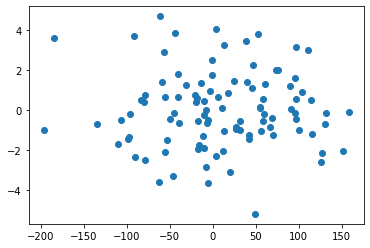

In [56]:
num_epochs = 50

for epoch in range(num_epochs):
    # forward pass
    y_pred = model(X)
    # compute loss
    loss = criterion(y_pred, y)
    # backprop
    loss.backward()
    # descend
    optimizer.step()
    # reset gradient
    optimizer.zero_grad()
    
    # print every 5 epochs
    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}: loss = {loss}')
        

# plot
# note, we will detach the tensor from the computational graph so that
# PyTorch doesn't try to track the plotting operations
predicted = model(X).detach()
residuals = y-predicted
residuals = residuals.cpu().numpy().reshape(100)
predicted = predicted.cpu().numpy().reshape(100)
plt.scatter(x = predicted, y = residuals)
    

---

## Logistic Regression

In this section, we'll build a Logistic Regression model to classify Breast Cancer cases. Here we will also practice building custom classes.

In [59]:
# load the breast cancer dataset
bc = datasets.load_breast_cancer()

# set up X and y
X,y = bc.data, bc.target

# get sample size and feature dimensions
n_samples, n_features = X.shape

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=117)

In [60]:
# scale data
scale = StandardScaler()

Xs_train = scale.fit_transform(X_train)
Xs_test = scale.transform(X_test)

In [68]:
# convert to Torch Tensors, we can either use torch.from_numpy() or torch.as_tensor()
Xs_train = torch.as_tensor(Xs_train, device='cuda', dtype=torch.float32)
Xs_test = torch.as_tensor(Xs_test, device = 'cuda', dtype=torch.float32)

y_train = torch.as_tensor(y_train, device = 'cuda', dtype=torch.float32)
y_test = torch.as_tensor(y_test, device='cuda', dtype=torch.float32)

# reshape output tensors
y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

### 1) Create Model

This time, let's try building a custom class.

In [74]:
# create custom class which subclasses from nn.Module
class LogisticRegression(nn.Module):
    
    def __init__(self, input_shape, **kwargs):
        # initialize as a member of the super class nn.Module
        super(LogisticRegression, self).__init__()
        # layers go here (we only have the output layer since we are doing logistic regression)
        self.linear = nn.Linear(input_shape, 1, **kwargs)
        
    def forward(self,x):
        y_pred = torch.nn.functional.sigmoid(self.linear(x))
        return y_pred
    

In [79]:
model = LogisticRegression(input_shape = n_features, device='cuda')

### 2) Set Loss and Optimizer

In [80]:
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

### 3) Training Loop

In [81]:
num_epochs = 100
for epoch in range(num_epochs):
    # forward pass
    y_preds = model(Xs_train)
    # loss
    loss = criterion(y_preds, y_train)
    # backprop
    loss.backward()
    # descend
    optimizer.step()
    # reset
    optimizer.zero_grad()
    
    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}: loss = {loss}')
        

# we want to evaluate on the test set, so we'll need to detach the weights from the computation graph
with torch.no_grad():
    # predict probabilities
    val_pred = model(Xs_test)
    # round predictions to get classification
    val_pred_cls = val_pred.round()
    acc = val_pred_cls.eq(y_test).sum()/float(y_test.shape[0])
    print(f'val accuracy = {acc:.4f}')

Epoch 5: loss = 0.1194760873913765
Epoch 10: loss = 0.07569771260023117
Epoch 15: loss = 0.05607548728585243
Epoch 20: loss = 0.04551072418689728
Epoch 25: loss = 0.039284683763980865
Epoch 30: loss = 0.03529727831482887
Epoch 35: loss = 0.03257334604859352
Epoch 40: loss = 0.0306075569242239
Epoch 45: loss = 0.0291022639721632
Epoch 50: loss = 0.02789505384862423
Epoch 55: loss = 0.02688427083194256
Epoch 60: loss = 0.026019582524895668
Epoch 65: loss = 0.02525569126009941
Epoch 70: loss = 0.02458094246685505
Epoch 75: loss = 0.023971201851963997
Epoch 80: loss = 0.023416809737682343
Epoch 85: loss = 0.02290918678045273
Epoch 90: loss = 0.02243766188621521
Epoch 95: loss = 0.021999789401888847
Epoch 100: loss = 0.021591395139694214
val accuracy = 0.9561
